In [0]:
# !pip install tensorflow==2.0

In [2]:
import tensorflow as tf
print(tf.__version__)

2.0.0


In [0]:
import numpy as np
import matplotlib.pyplot as plt

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [0]:
# !wget --no-check-certificate \
#     https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
#     -O /tmp/daily-min-temperatures.csv

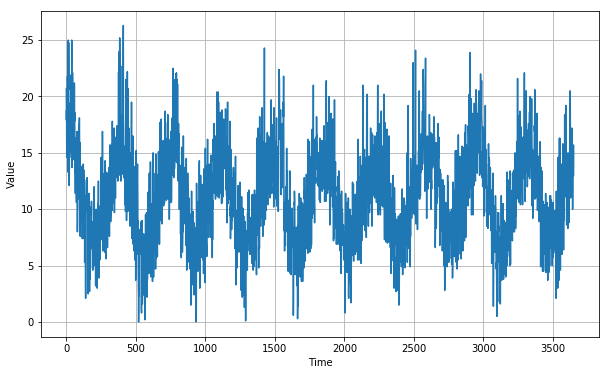

In [5]:
import pandas as pd

df = pd.read_csv('/tmp/daily-min-temperatures.csv').reset_index()

series = df['Temp'].values
time = df['index'].values
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [0]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [7]:
x_train.shape, x_valid.shape

((2500,), (1150,))

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
   series = tf.expand_dims(series, axis=-1) # (n, 1)
   dataset = tf.data.Dataset.from_tensor_slices(series)
   dataset = dataset.window(window_size+1, shift=1, drop_remainder=True) # (n-window_size-"1") windows
                                                                  # m = (n-window_size-1)
   dataset = dataset.flat_map(lambda w: w.batch(window_size + 1)) # (m, window_size+1, 1)
   dataset = dataset.shuffle(shuffle_buffer_size)
   dataset = dataset.map(lambda w: (w[:-1], w[1:]) ) # (m, window_size, 1), (m, window_size, 1)
   
   return dataset.batch(batch_size).prefetch(1) # (batch_size, window_size, 1), (batch_size, window_size, 1)


In [0]:
def model_forecast(model, series, window_size):
    series = tf.expand_dims(series, axis=-1) # (n, 1)
    dataset = tf.data.Dataset.from_tensor_slices(series) 
    dataset = dataset.window(window_size, shift=1, drop_remainder=True) # (n-window_size) windows
                                                               # m = (n-window_size)
    dataset = dataset.flat_map(lambda w: w.batch(window_size)) # (m, window_size, 1)
    dataset = dataset.batch(batch_size).prefetch(1) # (batch_size, window_size, 1)
    forecast = model.predict(dataset) 

    return forecast # (m, window_size, 1)

In [10]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 72
batch_size = 100
shuffle_buffer_size = 1250

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)


In [11]:
from tensorflow.keras.layers import Conv1D, LSTM, TimeDistributed, Dense, Lambda

model = tf.keras.models.Sequential([
  Conv1D(filters=72, kernel_size=5,
         strides=1, padding="causal",
         activation="relu",
         input_shape=[None, 1]), 
  LSTM(72, return_sequences=True),
  LSTM(72, return_sequences=True), # default activation is 'tanh' - range: [-1, 1]
  TimeDistributed(Dense(32, activation='relu')), # range: [0, 1]
  TimeDistributed(Dense(16, activation='relu')),
  TimeDistributed(Dense(1)),
  Lambda(lambda x: x*25) # scale to range: [0, 25]
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 72)          432       
_________________________________________________________________
lstm (LSTM)                  (None, None, 72)          41760     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 72)          41760     
_________________________________________________________________
time_distributed (TimeDistri (None, None, 32)          2336      
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 16)          528       
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 1)           17        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0

In [12]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=120, callbacks=[lr_schedule])

Epoch 1/120
25/25 [==============================] - 12s 480ms/step - loss: 13.0155 - mae: 13.5321
Epoch 2/120
25/25 [==============================] - 8s 311ms/step - loss: 13.0208 - mae: 13.5225
Epoch 3/120
25/25 [==============================] - 8s 307ms/step - loss: 13.0133 - mae: 13.5104
Epoch 4/120
25/25 [==============================] - 8s 304ms/step - loss: 12.9887 - mae: 13.4969
Epoch 5/120
25/25 [==============================] - 8s 307ms/step - loss: 12.9782 - mae: 13.4817
Epoch 6/120
25/25 [==============================] - 8s 311ms/step - loss: 12.9687 - mae: 13.4648
Epoch 7/120
25/25 [==============================] - 8s 311ms/step - loss: 12.9470 - mae: 13.4458
Epoch 8/120
25/25 [==============================] - 8s 312ms/step - loss: 12.9248 - mae: 13.4246
Epoch 9/120
25/25 [==============================] - 8s 313ms/step - loss: 12.8985 - mae: 13.4009
Epoch 10/120
25/25 [==============================] - 8s 311ms/step - loss: 12.8637 - mae: 13.3744
Epoch 11/120
25/25

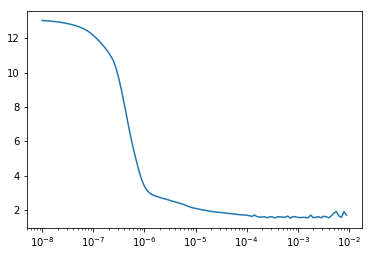

In [13]:
plt.semilogx(history.history["lr"], history.history["loss"])

In [0]:
'from here'

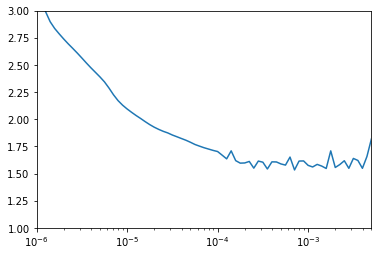

In [14]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 5e-3, 1, 3]);

In [15]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

# train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  Conv1D(filters=72, kernel_size=5,
         strides=1, padding="causal",
         activation="relu",
         input_shape=[None, 1]), 
  LSTM(72, return_sequences=True),
  LSTM(72, return_sequences=True), # default activation is 'tanh' - range: [-1, 1]
  TimeDistributed(Dense(32, activation='relu')), # range: [0, 1]
  TimeDistributed(Dense(16, activation='relu')),
  TimeDistributed(Dense(1)),
  Lambda(lambda x: x*25) # scale to range: [0, 25]
])


optimizer = tf.keras.optimizers.SGD(lr=1e-4, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)
                                    

Epoch 1/150
25/25 [==============================] - 11s 458ms/step - loss: 5.4721 - mae: 6.0178
Epoch 2/150
25/25 [==============================] - 8s 312ms/step - loss: 2.6934 - mae: 3.1570
Epoch 3/150
25/25 [==============================] - 8s 314ms/step - loss: 2.4250 - mae: 2.8851
Epoch 4/150
25/25 [==============================] - 8s 311ms/step - loss: 2.1100 - mae: 2.5643
Epoch 5/150
25/25 [==============================] - 8s 314ms/step - loss: 1.9158 - mae: 2.3693
Epoch 6/150
25/25 [==============================] - 8s 313ms/step - loss: 1.8798 - mae: 2.3326
Epoch 7/150
25/25 [==============================] - 8s 314ms/step - loss: 1.8562 - mae: 2.3087
Epoch 8/150
25/25 [==============================] - 8s 314ms/step - loss: 1.8418 - mae: 2.2936
Epoch 9/150
25/25 [==============================] - 8s 309ms/step - loss: 1.8283 - mae: 2.2798
Epoch 10/150
25/25 [==============================] - 8s 313ms/step - loss: 1.8185 - mae: 2.2701
Epoch 11/150
25/25 [==================

In [0]:
rnn_forecast = model_forecast(model, series, window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0] # only want the last one

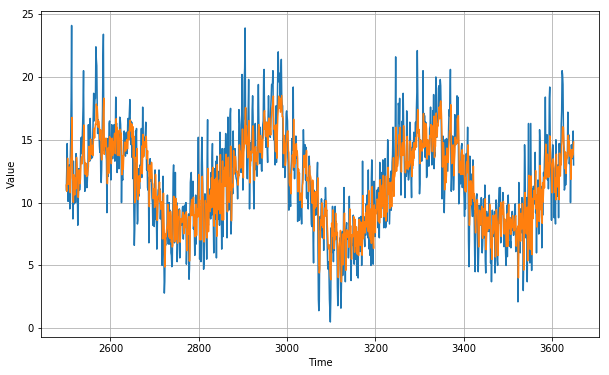

In [17]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [18]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

1.783474

In [19]:
print(rnn_forecast)

[11.388843  10.903939  12.347536  ... 13.7708025 13.806805  14.82412  ]


In [20]:
rnn_forecast.shape

(1150,)

In [21]:
pd.DataFrame(np.c_[rnn_forecast[-50:], x_valid[-50:]], columns=['predicted', 'true'])

,predicted,true
0,10.782170,12.6
1,13.027275,13.8
2,13.264009,14.6
3,13.483620,13.2
4,12.985134,12.3
5,12.728307,8.8
6,10.809267,10.7
7,11.987059,9.9
8,11.302249,8.3
9,10.224933,15.0


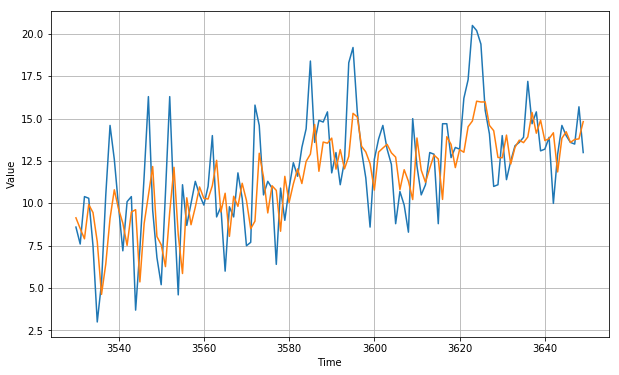

In [22]:
# zoom in on last 10 years
plt.figure(figsize=(10, 6))
plot_series(time_valid[-120:], x_valid[-120:])
plot_series(time_valid[-120:], rnn_forecast[-120:])

Indeed, the predicted values are not off of the true values by far. The offset is mostly within MAE value (1.78)